In [1]:
pip install boruta


[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.impute import KNNImputer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from boruta import BorutaPy

In [3]:
#Reading csv file 1
secom_labels_data='https://raw.githubusercontent.com/hugo-am/SECOM_HTWG2/refs/heads/Rebekah/secom_labels.data'
labels=pd.read_csv(secom_labels_data,header=None,sep=' ',names=['status','timestamp'])

In [4]:
#Generate an empty list to put column names in
column_list=[]

In [5]:
#Naming columns 0-590
for x in range(591):
    column_list.append(f'col{x}')

In [6]:
#Remove the first column name as it starts with 0
column_list.remove('col0')

In [7]:
#Reading csv file 2
secom_data='https://raw.githubusercontent.com/hugo-am/SECOM_HTWG2/refs/heads/Rebekah/secom.data'
data=pd.read_csv(secom_data,header=None,sep=' ',names=column_list)

In [8]:
#Data file has 590 columns and 1567 rows
print(data.shape)
data.head()

(1567, 590)


,col1,col2,col3,col4,col5,col6,col7,col8,col9,col10,...,col581,col582,col583,col584,col585,col586,col587,col588,col589,col590
0,3030.93,2564.00,2187.7333,1411.1265,1.3602,100.0,97.6133,0.1242,1.5005,0.0162,...,NaN,NaN,0.5005,0.0118,0.0035,2.3630,NaN,NaN,NaN,NaN
1,3095.78,2465.14,2230.4222,1463.6606,0.8294,100.0,102.3433,0.1247,1.4966,-0.0005,...,0.0060,208.2045,0.5019,0.0223,0.0055,4.4447,0.0096,0.0201,0.0060,208.2045
2,2932.61,2559.94,2186.4111,1698.0172,1.5102,100.0,95.4878,0.1241,1.4436,0.0041,...,0.0148,82.8602,0.4958,0.0157,0.0039,3.1745,0.0584,0.0484,0.0148,82.8602
3,2988.72,2479.90,2199.0333,909.7926,1.3204,100.0,104.2367,0.1217,1.4882,-0.0124,...,0.0044,73.8432,0.4990,0.0103,0.0025,2.0544,0.0202,0.0149,0.0044,73.8432
4,3032.24,2502.87,2233.3667,1326.5200,1.5334,100.0,100.3967,0.1235,1.5031,-0.0031,...,NaN,NaN,0.4800,0.4766,0.1045,99.3032,0.0202,0.0149,0.0044,73.8432


In [9]:
#Generate base dataframe
df=data.merge(labels,left_index=True,right_index=True)
df.head()

,col1,col2,col3,col4,col5,col6,col7,col8,col9,col10,...,col583,col584,col585,col586,col587,col588,col589,col590,status,timestamp
0,3030.93,2564.00,2187.7333,1411.1265,1.3602,100.0,97.6133,0.1242,1.5005,0.0162,...,0.5005,0.0118,0.0035,2.3630,NaN,NaN,NaN,NaN,-1,19/07/2008 11:55:00
1,3095.78,2465.14,2230.4222,1463.6606,0.8294,100.0,102.3433,0.1247,1.4966,-0.0005,...,0.5019,0.0223,0.0055,4.4447,0.0096,0.0201,0.0060,208.2045,-1,19/07/2008 12:32:00
2,2932.61,2559.94,2186.4111,1698.0172,1.5102,100.0,95.4878,0.1241,1.4436,0.0041,...,0.4958,0.0157,0.0039,3.1745,0.0584,0.0484,0.0148,82.8602,1,19/07/2008 13:17:00
3,2988.72,2479.90,2199.0333,909.7926,1.3204,100.0,104.2367,0.1217,1.4882,-0.0124,...,0.4990,0.0103,0.0025,2.0544,0.0202,0.0149,0.0044,73.8432,-1,19/07/2008 14:43:00
4,3032.24,2502.87,2233.3667,1326.5200,1.5334,100.0,100.3967,0.1235,1.5031,-0.0031,...,0.4800,0.4766,0.1045,99.3032,0.0202,0.0149,0.0044,73.8432,-1,19/07/2008 15:22:00


Missing Values Treatment - Remove 8 Features

In [10]:
#Missing values, Drop the 'status' and 'timestamp' columns
missing = df.drop(columns=['status', 'timestamp']).isna().sum().sort_values(ascending=False)

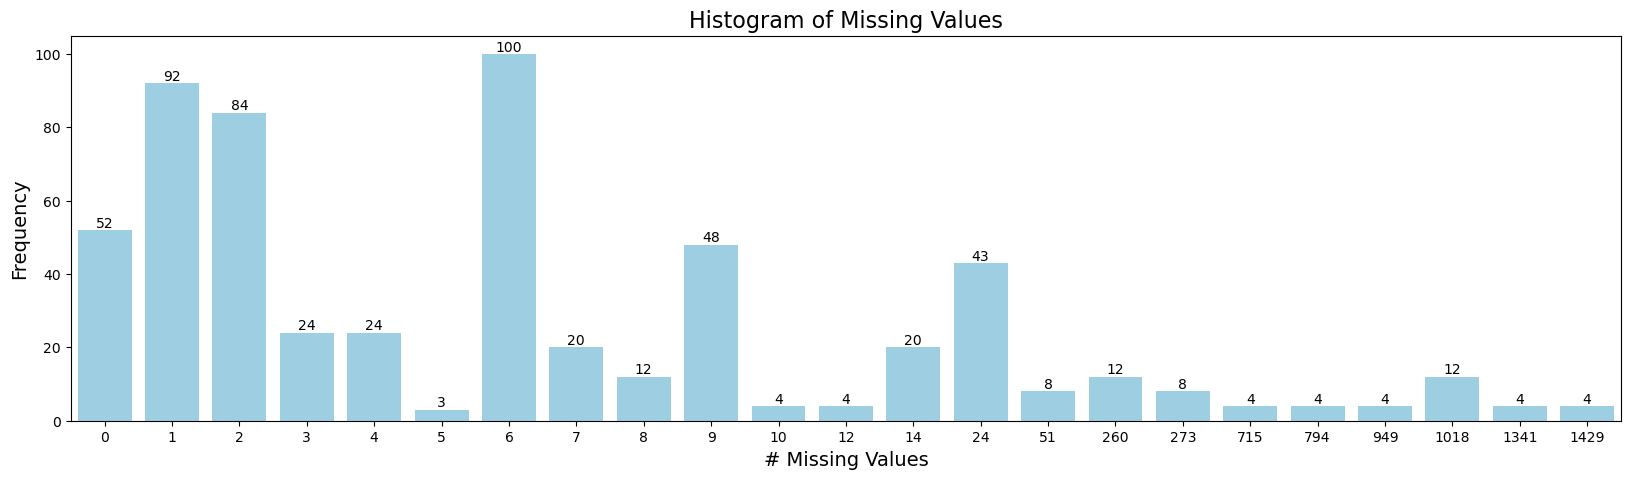

In [11]:
# Sort the missing value counts in descending order
missing_counts = missing.value_counts().sort_values(ascending=False)

# Plot the sorted histogram with axis labels
plt.figure(figsize=(20, 5))
ax = sns.barplot(x=missing_counts.index, y=missing_counts.values, alpha=0.9, color='skyblue')  # Set bar color to blue
plt.xlabel("# Missing Values", fontsize=14)  # Label for x-axis
plt.ylabel("Frequency", fontsize=14)        # Label for y-axis
plt.title("Histogram of Missing Values", fontsize=16)  # Title for the plot

# Add label markers above each bar
for container in ax.containers:
    ax.bar_label(container, fmt='%d', fontsize=10)

plt.show()

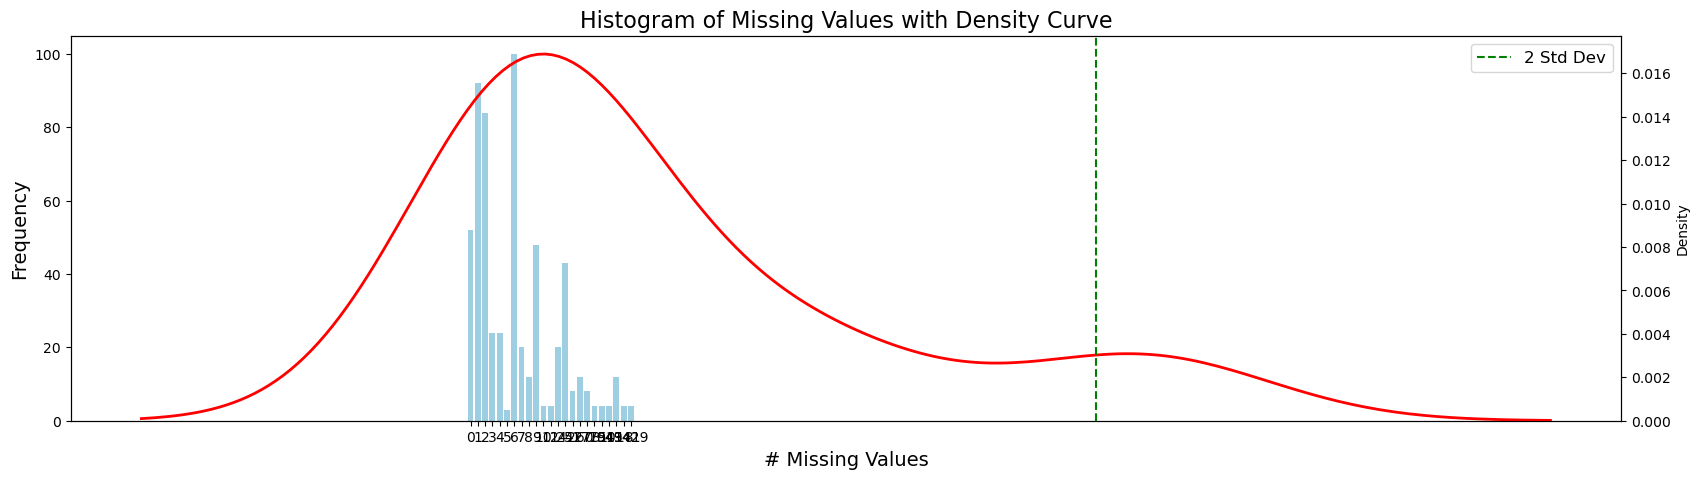

In [13]:
# Plot the histogram of missing values - DID NOT END UP USING THIS IN PRESENTATION DUE TO CURVE SHAPE
plt.figure(figsize=(20, 5))
ax = sns.barplot(x=missing_counts.index, y=missing_counts.values, alpha=0.9, color='skyblue')  # Set bar color to blue
plt.xlabel("# Missing Values", fontsize=14)  # Label for x-axis
plt.ylabel("Frequency", fontsize=14)        # Label for y-axis
plt.title("Histogram of Missing Values with Density Curve", fontsize=16)  # Title for the plot

# Plot the density curve
sns.kdeplot(missing_counts.values, color='red', linewidth=2, ax=ax.twinx())  # Use a secondary y-axis for the density curve

# Calculate the 2 standard deviation line
std_dev = missing_counts.std()
mean_value = missing_counts.mean()
two_std_line = mean_value + 2 * std_dev

# Add a vertical line at the 2 standard deviation mark
plt.axvline(x=two_std_line, color='green', linestyle='--', linewidth=1.5, label='2 Std Dev')

# Add legend
plt.legend(loc='upper right', fontsize=12)

plt.show()

In [14]:
# Calculate +3 and -3 standard deviations of missing VALUES to determine what % of missing values can be considered outliers and inform threshold for removal
plus_3_std = mean_value + 3 * std_dev
minus_3_std = mean_value - 3 * std_dev

print(f"+3 Standard Deviations: {plus_3_std}")
print(f"-3 Standard Deviations: {minus_3_std}")

+3 Standard Deviations: 115.82296048490468
-3 Standard Deviations: -64.51861265881774


In [15]:
#Analyze missing value basic counts and percentages (Avg Missing, Top 20% Pareto, Below 25% missing)
# Step 1: Calculate missing counts and missing percentages
missing_counts = data.isna().sum()
missing_percentage = (missing_counts / data.shape[0]) * 100  # 1567 rows

# Step 2: Basic counts
num_features_total = data.shape[1]
num_features_no_missing = (missing_counts == 0).sum()
num_features_25 = ((missing_counts > 0) & (missing_percentage < 25)).sum()
num_features_50 = ((missing_percentage >= 25) & (missing_percentage < 50)).sum()
num_features_half_missing = (missing_percentage >= 50).sum()
total_missing_values = data.isna().sum().sum()
total_missing_percentage = (total_missing_values / (data.shape[0] * data.shape[1])) * 100

print(f"Total features: {num_features_total}")
print(f"Features with NO missing values: {num_features_no_missing} ( {num_features_no_missing/num_features_total*100:.2f}% )")
print(f"Features with missing values between 0-25%: {num_features_25} ( {num_features_25/num_features_total*100:.2f}% )")
print(f"Features with missing values between 25-50%: {num_features_50} ( {num_features_50/num_features_total*100:.2f}% )")
print(f"Features with >=50% missing values: {num_features_half_missing} ( {num_features_half_missing/num_features_total*100:.2f}% )")
print(f"Total missing values in the 'data' dataset: {total_missing_values}")


# Step 3: Summary statistics
print("\nSummary of Missing Percentage:")
print(f"Minimum missing %: {missing_percentage.min():.2f}%")
print(f"Maximum missing %: {missing_percentage.max():.2f}%")
print(f"Mean missing %: {missing_percentage.mean():.2f}%")
print(f"Total percentage of missing values in the 'data' dataset: {total_missing_percentage:.2f}%")
print(f"Median missing %: {missing_percentage.median():.2f}%")

# Step 4: Top 10 features with most missingness
top_missing_features = missing_percentage.sort_values(ascending=False).head(10)
print("\nTop 10 features with highest missingness:")
print(top_missing_features)

Total features: 590
Features with NO missing values: 52 ( 8.81% )
Features with missing values between 0-25%: 506 ( 85.76% )
Features with missing values between 25-50%: 4 ( 0.68% )
Features with >=50% missing values: 28 ( 4.75% )
Total missing values in the 'data' dataset: 41951

Summary of Missing Percentage:
Minimum missing %: 0.00%
Maximum missing %: 91.19%
Mean missing %: 4.54%
Total percentage of missing values in the 'data' dataset: 4.54%
Median missing %: 0.38%

Top 10 features with highest missingness:
col158    91.193363
col293    91.193363
col294    91.193363
col159    91.193363
col493    85.577537
col359    85.577537
col86     85.577537
col221    85.577537
col247    64.964901
col110    64.964901
dtype: float64


In [16]:
#calculate 3s of missing PERCENT to determine what % of missing values can be considered outliers and inform threshold for removal
mean_missing_percentage = missing_percentage.mean()
std_missing_percentage = missing_percentage.std()

plus_3_std_missing_percentage = mean_missing_percentage + 3 * std_missing_percentage
minus_3_std_missing_percentage = mean_missing_percentage - 3 * std_missing_percentage

print(f"+3 Standard Deviations: {plus_3_std_missing_percentage}")
print(f"-3 Standard Deviations: {minus_3_std_missing_percentage}")

+3 Standard Deviations: 50.8395075614022
-3 Standard Deviations: -41.76440994423456


In [17]:
#calculate 4s of missing PERCENT to determine what % of missing values can be considered outliers and inform threshold for removal
mean_missing_percentage = missing_percentage.mean()
std_missing_percentage = missing_percentage.std()

plus_4_std_missing_percentage = mean_missing_percentage + 4 * std_missing_percentage
minus_4_std_missing_percentage = mean_missing_percentage - 4 * std_missing_percentage

print(f"+4 Standard Deviations: {plus_4_std_missing_percentage}")
print(f"-4 Standard Deviations: {minus_4_std_missing_percentage}")

+4 Standard Deviations: 66.27349381234166
-4 Standard Deviations: -57.19839619517402


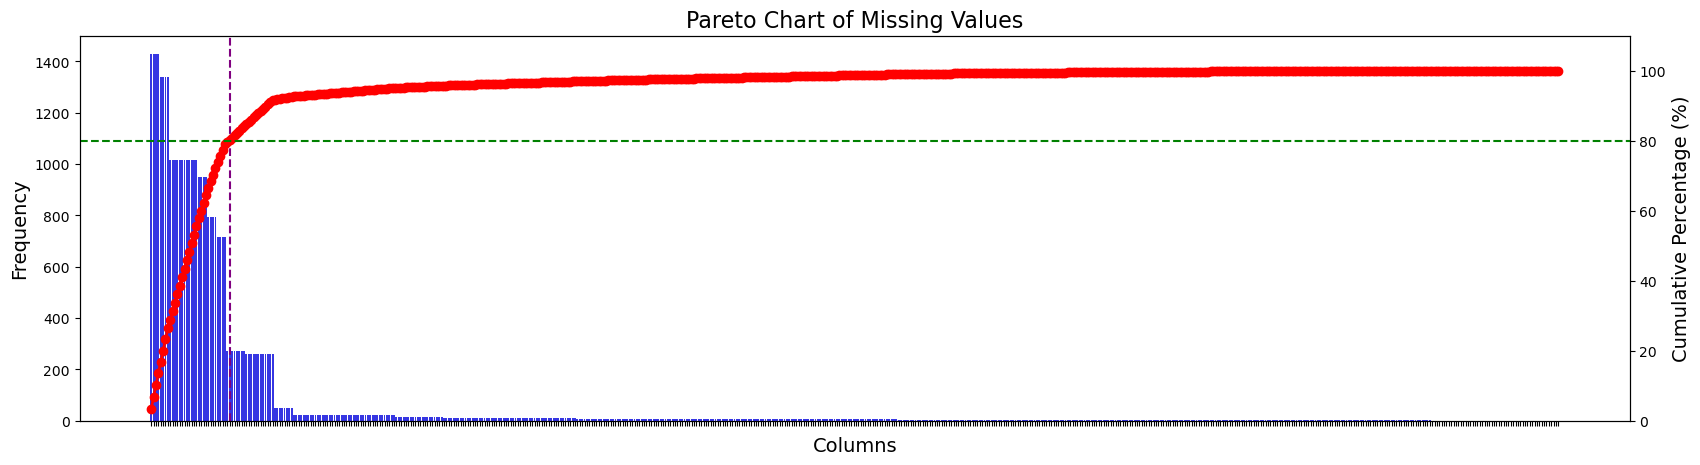

In [18]:
#Pareto Chart of Missing Values as a Count of Values
# # Calculate missing value counts and sort them in descending order
missing_counts = df.isna().sum().sort_values(ascending=False)

# Calculate cumulative percentage
cumulative_percentage = missing_counts.cumsum() / missing_counts.sum() * 100

# Create a figure and axis
fig, ax1 = plt.subplots(figsize=(20, 5))

# Plot the bar chart for missing value counts
sns.barplot(x=missing_counts.index, y=missing_counts.values, alpha=0.9, ax=ax1, color='blue')
ax1.set_ylabel('Frequency', fontsize=14)
ax1.set_xlabel('Columns', fontsize=14)
ax1.set_title('Pareto Chart of Missing Values', fontsize=16)

# Create a second y-axis for the cumulative percentage
ax2 = ax1.twinx()
ax2.plot(missing_counts.index, cumulative_percentage, color='red', marker='o', linewidth=2)
ax2.set_ylabel('Cumulative Percentage (%)', fontsize=14)
ax2.set_ylim(0, 110)  # Ensure the percentage scale goes slightly above 100 for clarity

# Rotate x-axis labels for better readability
ax1.set_xticklabels([])

# Add horizontal line at 80% cumulative percentage
ax2.axhline(y=80, color='green', linestyle='--', linewidth=1.5)

# Find the column where the cumulative percentage exceeds 80%
threshold_index = cumulative_percentage[cumulative_percentage > 80].index[0]

# Add vertical line at the threshold column
ax1.axvline(x=threshold_index, color='purple', linestyle='--', linewidth=1.5)

plt.show()

In [19]:
# Combine missing counts and cumulative percentage into a DataFrame for better readability
missing_pct=missing_counts.values / df.shape[0] * 100
pareto_data = pd.DataFrame({
    'Column': missing_counts.index,
    'Missing %': missing_pct,
    'Cumulative Percentage': cumulative_percentage.values
})

# Remove any limit on number of displayed rows and columns
pd.set_option('display.max_rows', 30)
pd.set_option('display.max_columns', None)
# Now display the full DataFrame
pareto_data

,Column,Missing %,Cumulative Percentage
0,col158,91.193363,3.406355
1,col293,91.193363,6.812710
2,col294,91.193363,10.219065
3,col159,91.193363,13.625420
4,col493,85.577537,16.822007
...,...,...,...
587,col121,0.000000,100.000000
588,col157,0.000000,100.000000
589,col496,0.000000,100.000000
590,col495,0.000000,100.000000


In [20]:
pareto_data.head(30)

,Column,Missing %,Cumulative Percentage
0,col158,91.193363,3.406355
1,col293,91.193363,6.812710
2,col294,91.193363,10.219065
3,col159,91.193363,13.625420
4,col493,85.577537,16.822007
5,col359,85.577537,20.018593
6,col86,85.577537,23.215180
7,col221,85.577537,26.411766
8,col247,64.964901,28.838407
9,col110,64.964901,31.265047


In [21]:
pareto_data

,Column,Missing %,Cumulative Percentage
0,col158,91.193363,3.406355
1,col293,91.193363,6.812710
2,col294,91.193363,10.219065
3,col159,91.193363,13.625420
4,col493,85.577537,16.822007
...,...,...,...
587,col121,0.000000,100.000000
588,col157,0.000000,100.000000
589,col496,0.000000,100.000000
590,col495,0.000000,100.000000


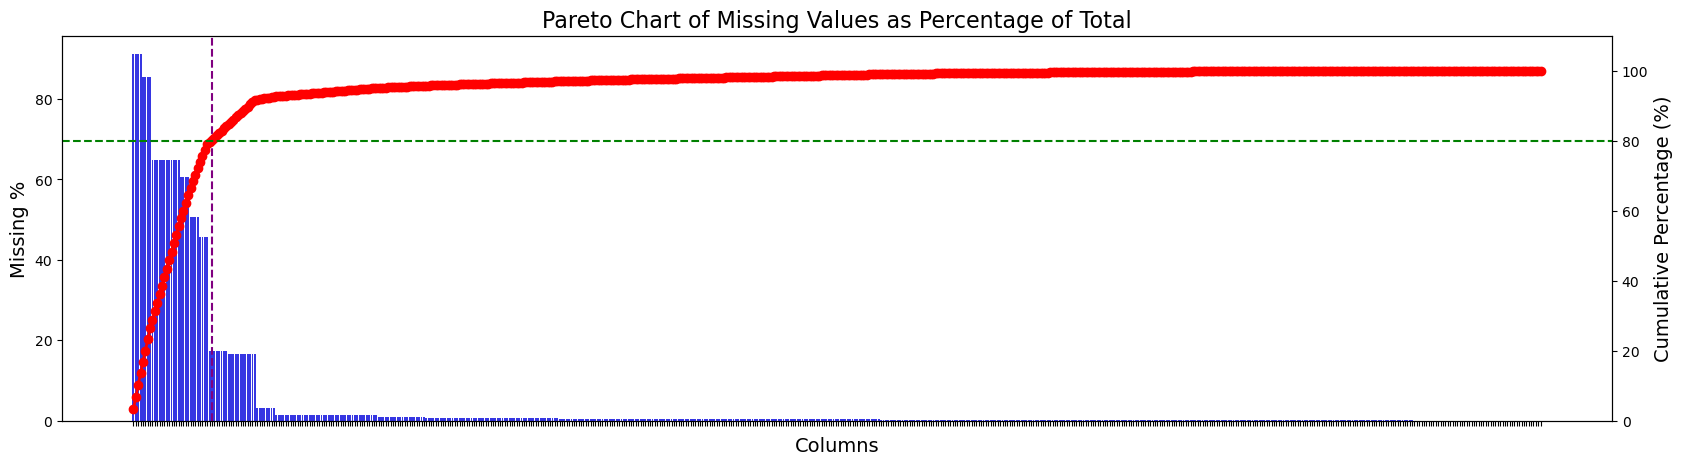

In [22]:
#Pareto Chart of Missing Values as a % of Total - USED IN PRESENTATION
# # Create a figure and axis
fig, ax1 = plt.subplots(figsize=(20, 5))

# Plot the bar chart for missing percentages
sns.barplot(x=pareto_data['Column'], y=pareto_data['Missing %'], alpha=0.9, ax=ax1, color='blue')
ax1.set_ylabel('Missing %', fontsize=14)
ax1.set_xlabel('Columns', fontsize=14)
ax1.set_title('Pareto Chart of Missing Values as Percentage of Total', fontsize=16)

# Create a second y-axis for the cumulative percentage
ax2 = ax1.twinx()
ax2.plot(pareto_data['Column'], pareto_data['Cumulative Percentage'], color='red', marker='o', linewidth=2)
ax2.set_ylabel('Cumulative Percentage (%)', fontsize=14)
ax2.set_ylim(0, 110)  # Ensure the percentage scale goes slightly above 100 for clarity

# Rotate x-axis labels for better readability
ax1.set_xticklabels([])

# Add horizontal line at 80% cumulative percentage
ax2.axhline(y=80, color='green', linestyle='--', linewidth=1.5)

# Find the column where the cumulative percentage exceeds 80%
threshold_column = pareto_data.loc[pareto_data['Cumulative Percentage'] > 80, 'Column'].iloc[0]

# Add vertical line at the threshold column
threshold_index = pareto_data[pareto_data['Column'] == threshold_column].index[0]
ax1.axvline(x=threshold_index, color='purple', linestyle='--', linewidth=1.5)

plt.show()

In [23]:
# Sort the DataFrame by 'Cumulative Percentage' in descending order
sorted_pareto_data = pareto_data.sort_values(by='Cumulative Percentage', ascending=False)

# Print the 'Missing %' and 'Cumulative Percentage' columns
print(sorted_pareto_data[['Missing %', 'Cumulative Percentage']])

     Missing %  Cumulative Percentage
591   0.000000             100.000000
564   0.000000             100.000000
562   0.000000             100.000000
561   0.000000             100.000000
560   0.000000             100.000000
..         ...                    ...
4    85.577537              16.822007
3    91.193363              13.625420
2    91.193363              10.219065
1    91.193363               6.812710
0    91.193363               3.406355

[592 rows x 2 columns]


Duplicate Row Treatment - Remove 0 Features

In [24]:
#Check for duplicate rows (there are 0)
df.duplicated().sum()

0

Zero Variance Treatment - No Action

In [25]:
#Zero volatility columns are those with 0 or near 0 mean and std
df.describe().T

,count,mean,std,min,25%,50%,75%,max
col1,1561.0,3014.452896,73.621787,2743.2400,2966.260000,3011.4900,3056.6500,3356.3500
col2,1560.0,2495.850231,80.407705,2158.7500,2452.247500,2499.4050,2538.8225,2846.4400
col3,1553.0,2200.547318,29.513152,2060.6600,2181.044400,2201.0667,2218.0555,2315.2667
col4,1553.0,1396.376627,441.691640,0.0000,1081.875800,1285.2144,1591.2235,3715.0417
col5,1553.0,4.197013,56.355540,0.6815,1.017700,1.3168,1.5257,1114.5366
...,...,...,...,...,...,...,...,...
col587,1566.0,0.021458,0.012358,-0.0169,0.013425,0.0205,0.0276,0.1028
col588,1566.0,0.016475,0.008808,0.0032,0.010600,0.0148,0.0203,0.0799
col589,1566.0,0.005283,0.002867,0.0010,0.003300,0.0046,0.0064,0.0286
col590,1566.0,99.670066,93.891919,0.0000,44.368600,71.9005,114.7497,737.3048


Low Variability Investigation - No Action

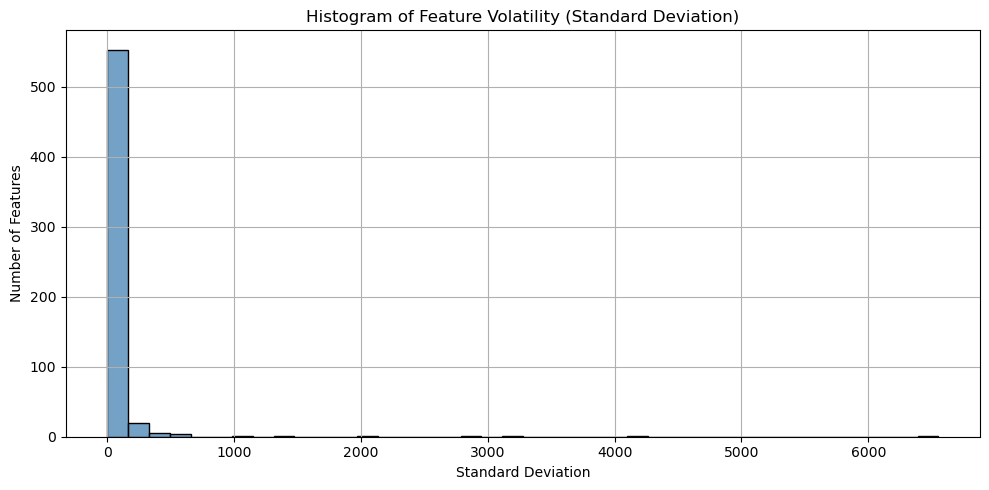

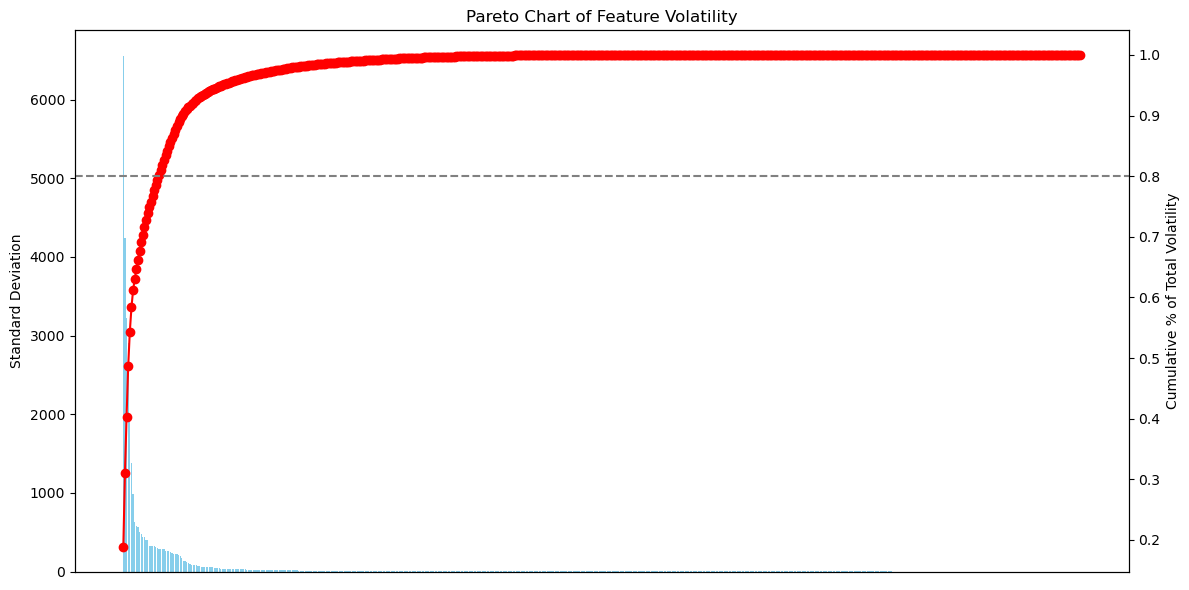

Number of features with low (but non-zero) volatility: 55
Percentage of features with low (but non-zero) volatility: 9.32%


In [26]:
# Calculate standard deviation (volatility) for each sensor column
std_devs = data.std().sort_values()

# ----------- Histogram of Feature Volatility -----------
plt.figure(figsize=(10, 5))
sns.histplot(std_devs, bins=40, kde=False, color='steelblue')
plt.title("Histogram of Feature Volatility (Standard Deviation)")
plt.xlabel("Standard Deviation")
plt.ylabel("Number of Features")
plt.grid(True)
plt.tight_layout()
plt.show()

# ----------- Pareto Chart of Feature Volatility -----------
# Sort in descending order for Pareto
sorted_std = std_devs[::-1]
cumulative = sorted_std.cumsum() / sorted_std.sum()

fig, ax1 = plt.subplots(figsize=(12, 6))

# Bar plot (standard deviation per column)
ax1.bar(sorted_std.index, sorted_std.values, color='skyblue')
ax1.set_ylabel('Standard Deviation')
ax1.set_xticks([])
ax1.set_title('Pareto Chart of Feature Volatility')

# Cumulative line plot
ax2 = ax1.twinx()
ax2.plot(cumulative.values, color='red', marker='o')
ax2.axhline(0.8, color='gray', linestyle='dashed')  # 80% line
ax2.set_ylabel('Cumulative % of Total Volatility')
plt.tight_layout()
plt.show()

# calculate low volatility features

# Calculate standard deviation excluding 'status' and 'timestamp'
std_devs = df.drop(columns=['status', 'timestamp']).std()
# Define a threshold for low volatility
low_volatility_threshold = 0.01

# Number of features with low but non-zero volatility
low_volatility_features = (std_devs > 0) & (std_devs < low_volatility_threshold)

# Calculate counts and percentages
num_low_volatility = low_volatility_features.sum()
percent_low_volatility = (num_low_volatility / len(std_devs)) * 100

print(f"Number of features with low (but non-zero) volatility: {num_low_volatility}")
print(f"Percentage of features with low (but non-zero) volatility: {percent_low_volatility:.2f}%")


Outlier Investigation - No Action


In [27]:
#note that the total outliers differs from ppt 1 because pp1 only removed zero volatility columns before calculating outliers; this version removes zero volatility AND >65% missing values. 
df_cleaned = data.copy()
# Calculate Z-scores
z_scores = (df_cleaned - df_cleaned.mean()) / df_cleaned.std()

# Define thresholds
thresholds = [3, 4]

for threshold in thresholds:
    # Identify outliers: where |Z| > threshold
    outliers = np.abs(z_scores) > threshold

    # Total outliers per row and count of rows with any outliers
    outliers_per_row = outliers.sum(axis=1)
    total_outlier_rows = (outliers_per_row > 0).sum()

    # Total outliers per column and count of columns with any outliers
    outliers_per_col = outliers.sum(axis=0)
    total_outlier_cols = (outliers_per_col > 0).sum()

    # Total outlier values in the dataset
    total_outliers = outliers.sum().sum()
    total_values = df_cleaned.size
    percent_outliers = (total_outliers / total_values) * 100

    # Print results
    print(f"\n--- Z-score threshold > {threshold} ---")
    print(f"Total rows with outliers: {total_outlier_rows} out of {df_cleaned.shape[0]} rows")
    print(f"Total columns with outliers: {total_outlier_cols} out of {df_cleaned.shape[1]} columns")
    print(f"Total outlier values: {total_outliers} out of {total_values} ({percent_outliers:.2f}%)")



--- Z-score threshold > 3 ---
Total rows with outliers: 1265 out of 1567 rows
Total columns with outliers: 440 out of 590 columns
Total outlier values: 6116 out of 924530 (0.66%)

--- Z-score threshold > 4 ---
Total rows with outliers: 762 out of 1567 rows
Total columns with outliers: 402 out of 590 columns
Total outlier values: 3258 out of 924530 (0.35%)


Correlation Investigation - No Action

In [28]:
#calculate standard deviation of column subsamples
print(f"Col1 Std: {data['col1'].std()}")
print(f"Col102 Std: {data['col102'].std()}")
print(f"Col64 Std: {data['col64'].std()}")

Col1 Std: 73.62178674853081
Col102 Std: 0.00022076237351255305
Col64 Std: 7.1198631082108985


In [29]:
data.head()

,col1,col2,col3,col4,col5,col6,col7,col8,col9,col10,col11,col12,col13,col14,col15,col16,col17,col18,col19,col20,col21,col22,col23,col24,col25,col26,col27,col28,col29,col30,col31,col32,col33,col34,col35,col36,col37,col38,col39,col40,col41,col42,col43,col44,col45,col46,col47,col48,col49,col50,col51,col52,col53,col54,col55,col56,col57,col58,col59,col60,col61,col62,col63,col64,col65,col66,col67,col68,col69,col70,col71,col72,col73,col74,col75,col76,col77,col78,col79,col80,col81,col82,col83,col84,col85,col86,col87,col88,col89,col90,col91,col92,col93,col94,col95,col96,col97,col98,col99,col100,col101,col102,col103,col104,col105,col106,col107,col108,col109,col110,col111,col112,col113,col114,col115,col116,col117,col118,col119,col120,col121,col122,col123,col124,col125,col126,col127,col128,col129,col130,col131,col132,col133,col134,col135,col136,col137,col138,col139,col140,col141,col142,col143,col144,col145,col146,col147,col148,col149,col150,col151,col152,col153,col154,col155,col156,col157,col158,col159,col160,col161,col162,col163,col164,col165,col166,col167,col168,col169,col170,col171,col172,col173,col174,col175,col176,col177,col178,col179,col180,col181,col182,col183,col184,col185,col186,col187,col188,col189,col190,col191,col192,col193,col194,col195,col196,col197,col198,col199,col200,col201,col202,col203,col204,col205,col206,col207,col208,col209,col210,col211,col212,col213,col214,col215,col216,col217,col218,col219,col220,col221,col222,col223,col224,col225,col226,col227,col228,col229,col230,col231,col232,col233,col234,col235,col236,col237,col238,col239,col240,col241,col242,col243,col244,col245,col246,col247,col248,col249,col250,col251,col252,col253,col254,col255,col256,col257,col258,col259,col260,col261,col262,col263,col264,col265,col266,col267,col268,col269,col270,col271,col272,col273,col274,col275,col276,col277,col278,col279,col280,col281,col282,col283,col284,col285,col286,col287,col288,col289,col290,col291,col292,col293,col294,col295,col296,col297,col298,col299,col300,col301,col302,col303,col304,col305,col306,col307,col308,col309,col310,col311,col312,col313,col314,col315,col316,col317,col318,col319,col320,col321,col322,col323,col324,col325,col326,col327,col328,col329,col330,col331,col332,col333,col334,col335,col336,col337,col338,col339,col340,col341,col342,col343,col344,col345,col346,col347,col348,col349,col350,col351,col352,col353,col354,col355,col356,col357,col358,col359,col360,col361,col362,col363,col364,col365,col366,col367,col368,col369,col370,col371,col372,col373,col374,col375,col376,col377,col378,col379,col380,col381,col382,col383,col384,col385,col386,col387,col388,col389,col390,col391,col392,col393,col394,col395,col396,col397,col398,col399,col400,col401,col402,col403,col404,col405,col406,col407,col408,col409,col410,col411,col412,col413,col414,col415,col416,col417,col418,col419,col420,col421,col422,col423,col424,col425,col426,col427,col428,col429,col430,col431,col432,col433,col434,col435,col436,col437,col438,col439,col440,col441,col442,col443,col444,col445,col446,col447,col448,col449,col450,col451,col452,col453,col454,col455,col456,col457,col458,col459,col460,col461,col462,col463,col464,col465,col466,col467,col468,col469,col470,col471,col472,col473,col474,col475,col476,col477,col478,col479,col480,col481,col482,col483,col484,col485,col486,col487,col488,col489,col490,col491,col492,col493,col494,col495,col496,col497,col498,col499,col500,col501,col502,col503,col504,col505,col506,col507,col508,col509,col510,col511,col512,col513,col514,col515,col516,col517,col518,col519,col520,col521,col522,col523,col524,col525,col526,col527,col528,col529,col530,col531,col532,col533,col534,col535,col536,col537,col538,col539,col540,col541,col542,col543,col544,col545,col546,col547,col548,col549,col550,col551,col552,col553,col554,col555,col556,col557,col558,col559,col560,col561,col562,col563,col564,col565,col566,col567,col568,col569,col570,col571,col572,col573,col574,col575,col576,col577,col578,col579,col580,col581,col582,col583,col584,col585,col586,col58

Text(0.5, 1.0, 'Single Digit SD Feature - Example 2 (col64)')

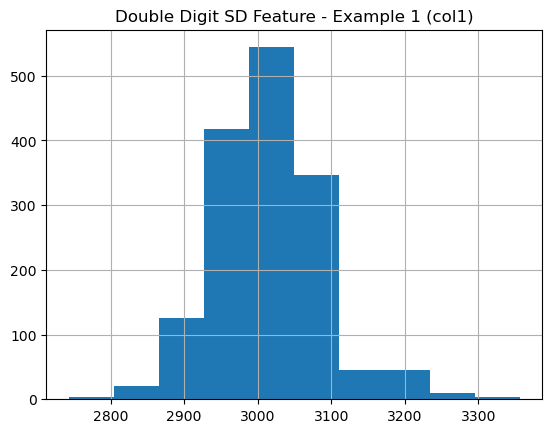

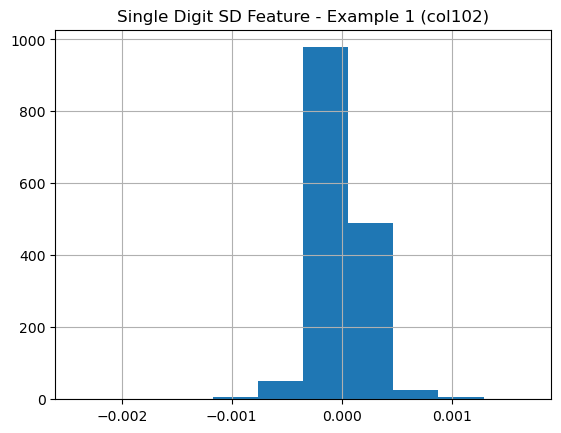

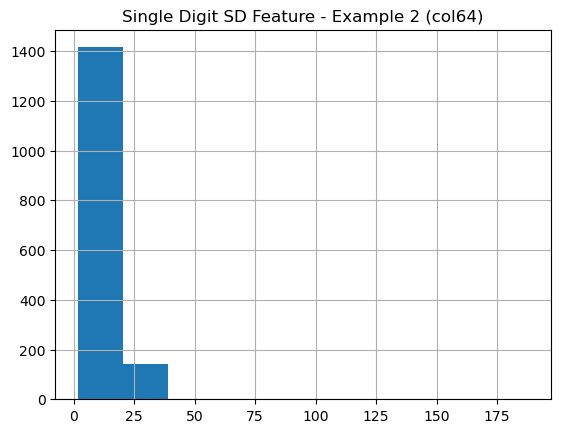

In [30]:
#Analyze histograms of a subsample of single digit SD vs double digit SD features to see if they are normally distributed
#double digit SD feature example
data[['col1']].hist()
plt.title('Double Digit SD Feature - Example 1 (col1)')

#single digit SD feature examples
data[['col102']].hist()
plt.title('Single Digit SD Feature - Example 1 (col102)')

data[['col64']].hist()
plt.title('Single Digit SD Feature - Example 2 (col64)')

['col163', 'col162', 'col298', 'col25', 'col297', 'col24', 'col160', 'col22', 'col161', 'col205', 'col141', 'col295']


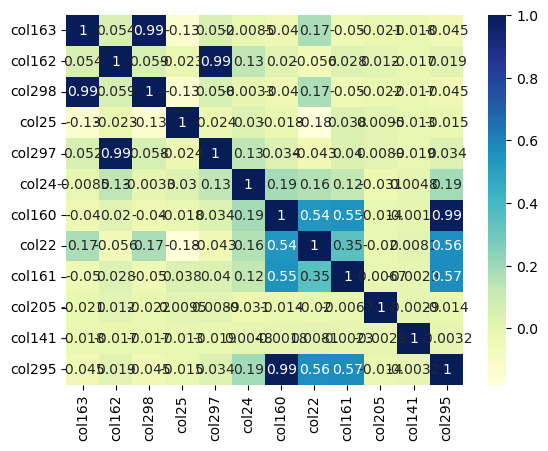

In [31]:
# Print the 12 columns with the highest standard deviation
top_12_std_cols = data.std().sort_values(ascending=False).head(12)
print(top_12_std_cols.index.tolist())

# Compute correlation matrix
corr_matrix_12= data[top_12_std_cols.index.tolist()].corr()

# Plot correlation heatmap
sns.heatmap(corr_matrix_12, cmap="YlGnBu", annot=True)

# Display heatmap
plt.show()

['col4', 'col226', 'col159', 'col91', 'col512', 'col420', 'col500', 'col501', 'col68', 'col23']


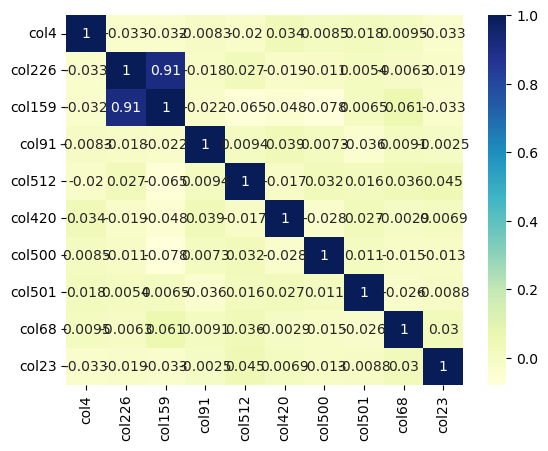

In [32]:
#print top standard deviation columns #12-22
std_sorted = data.std().sort_values(ascending=False)
top_12_22_std_cols = std_sorted.index[12:22].tolist()
print(top_12_22_std_cols)

# Plot correlation heatmap
corr_matrix_12_22 = data[top_12_22_std_cols].corr()
sns.heatmap(corr_matrix_12_22, cmap="YlGnBu", annot=True)
plt.show()

Lowest 10 double digit standard deviation columns:
col247    10.045084
col472    10.174117
col478    10.185026
col570    10.213294
col198    10.552162
col429    10.632730
col517    10.783880
col206    11.541083
col67     11.623078
col47     12.170315
dtype: float64


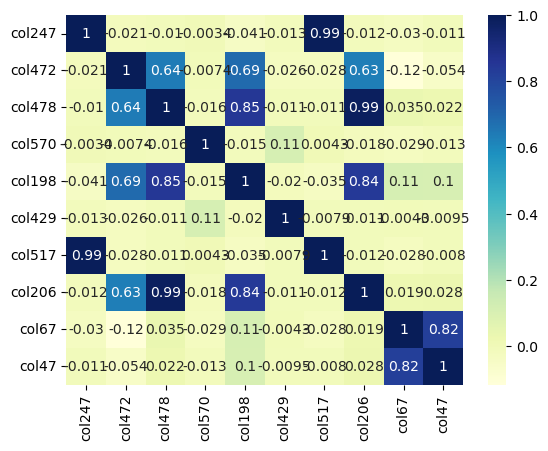

In [33]:
# Print the lowest 10 double digit standard deviation columns
# Find columns with double digit standard deviation (>=10 and <100)
double_digit_std = std_sorted[(std_sorted >= 10) & (std_sorted < 100)]
lowest_10_double_digit_std = double_digit_std[(double_digit_std >= 10) & (double_digit_std < 100)].sort_values().head(10)
print("Lowest 10 double digit standard deviation columns:")
print(lowest_10_double_digit_std)

#plot correlation heatmap of lowest 10 double digit standard deviation columns
corr_matrix_lowest_10_double_digit = data[lowest_10_double_digit_std.index].corr()
sns.heatmap(corr_matrix_lowest_10_double_digit, cmap="YlGnBu", annot=True)
plt.show()

Execute Train/Test Split

In [35]:
from sklearn.model_selection import StratifiedKFold

# Ensure the 'status' column is included for stratification
data['status'] = labels['status']

# Initialize StratifiedKFold
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Create and store the fold indices
fold_indices = list(skf.split(data, data['status']))

# Print information about the folds
print("Stratified 5-Fold Cross Validation splits:")
for fold_idx, (train_idx, val_idx) in enumerate(fold_indices, 1):
    train_fold = data.iloc[train_idx]
    val_fold = data.iloc[val_idx]
    print(f"\nFold {fold_idx}:")
    print(f"Training set shape: {train_fold.shape}")
    print(f"Validation set shape: {val_fold.shape}")
    print(f"Training set class distribution:\n{train_fold['status'].value_counts()}")
    print(f"Validation set class distribution:\n{val_fold['status'].value_counts()}")

Stratified 5-Fold Cross Validation splits:

Fold 1:
Training set shape: (1253, 591)
Validation set shape: (314, 591)
Training set class distribution:
status
-1    1170
 1      83
Name: count, dtype: int64
Validation set class distribution:
status
-1    293
 1     21
Name: count, dtype: int64

Fold 2:
Training set shape: (1253, 591)
Validation set shape: (314, 591)
Training set class distribution:
status
-1    1170
 1      83
Name: count, dtype: int64
Validation set class distribution:
status
-1    293
 1     21
Name: count, dtype: int64

Fold 3:
Training set shape: (1254, 591)
Validation set shape: (313, 591)
Training set class distribution:
status
-1    1170
 1      84
Name: count, dtype: int64
Validation set class distribution:
status
-1    293
 1     20
Name: count, dtype: int64

Fold 4:
Training set shape: (1254, 591)
Validation set shape: (313, 591)
Training set class distribution:
status
-1    1171
 1      83
Name: count, dtype: int64
Validation set class distribution:
status
-1 

Describe Train/Test Split Distributions


📊 Label Distribution (Counts):
        Full Data  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5
status                                                   
-1           1463     293     293     293     292     292
 1            104      21      21      20      21      21


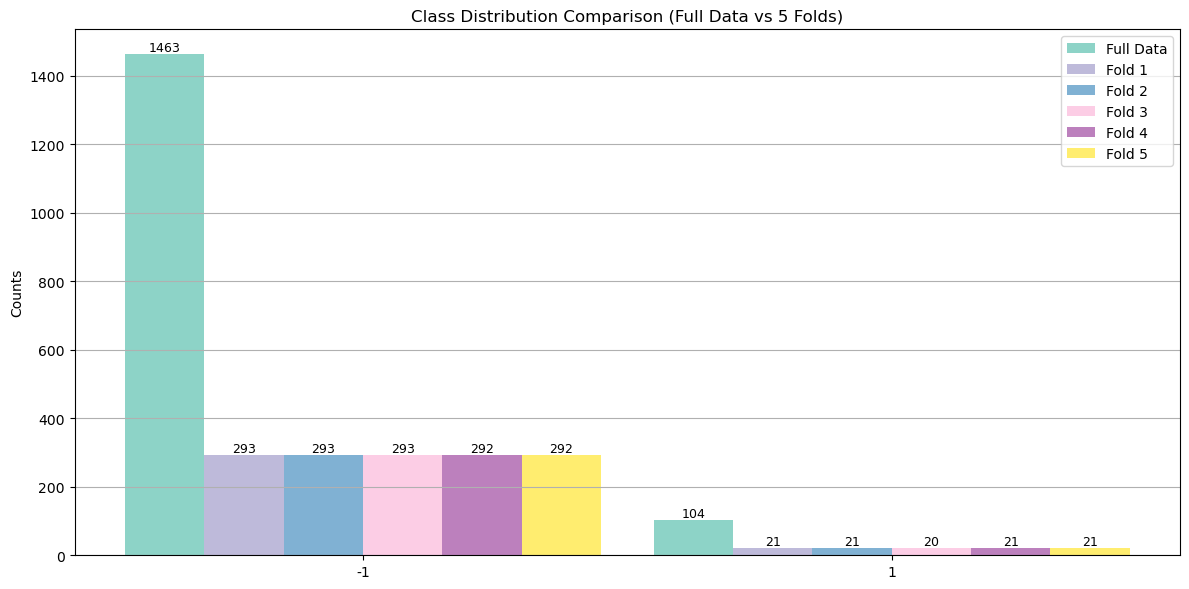

In [36]:
# Summarize the distributions
full_counts = data['status'].value_counts().sort_index()

# Create a dictionary to store fold distributions
fold_distributions = {'Full Data': full_counts}
for fold_idx, (train_idx, val_idx) in enumerate(fold_indices, 1):
    fold_data = data.iloc[val_idx]
    fold_counts = fold_data['status'].value_counts().sort_index()
    fold_distributions[f'Fold {fold_idx}'] = fold_counts

# Combine into a single table
distribution_table = pd.DataFrame(fold_distributions)

print("\n📊 Label Distribution (Counts):")
print(distribution_table)

# Visualization
labels_list = distribution_table.index.tolist()
x = np.arange(len(labels_list))
width = 0.15  # Reduced width to accommodate more bars

fig, ax = plt.subplots(figsize=(12, 6))  # Increased figure width

# Plot bars for each dataset
colors = plt.cm.Set3(np.linspace(0, 1, 6))  # Color palette for 6 bars
for idx, (column, color) in enumerate(zip(distribution_table.columns, colors)):
    offset = width * (idx - 2.5)
    rects = ax.bar(x + offset, distribution_table[column], width, 
                   label=column, color=color)
    ax.bar_label(rects, fmt='%d', fontsize=9)

ax.set_ylabel('Counts')
ax.set_title('Class Distribution Comparison (Full Data vs 5 Folds)')
ax.set_xticks(x)
ax.set_xticklabels(labels_list)
ax.legend()
plt.grid(True, axis='y')
plt.tight_layout()

plt.show()

In [37]:
# Show the full dataset shape
print(f"Full dataset shape: {data.shape}")

# Show shapes for each fold
print("\nFold shapes:")
for fold_idx, (train_idx, val_idx) in enumerate(fold_indices, 1):
    train_fold = data.iloc[train_idx]
    val_fold = data.iloc[val_idx]
    print(f"\nFold {fold_idx}:")
    print(f"Training set:   {train_fold.shape} ({len(train_idx)} samples)")
    print(f"Validation set: {val_fold.shape} ({len(val_idx)} samples)")

Full dataset shape: (1567, 591)

Fold shapes:

Fold 1:
Training set:   (1253, 591) (1253 samples)
Validation set: (314, 591) (314 samples)

Fold 2:
Training set:   (1253, 591) (1253 samples)
Validation set: (314, 591) (314 samples)

Fold 3:
Training set:   (1254, 591) (1254 samples)
Validation set: (313, 591) (313 samples)

Fold 4:
Training set:   (1254, 591) (1254 samples)
Validation set: (313, 591) (313 samples)

Fold 5:
Training set:   (1254, 591) (1254 samples)
Validation set: (313, 591) (313 samples)


In [38]:
total_missing_values

41951

Zero Variance Removal

In [41]:
# Initialize a list to store zero variance columns for each fold
fold_zero_var_info = []

# Process each fold
for fold_idx, (train_idx, val_idx) in enumerate(fold_indices, 1):
    train_fold = data.iloc[train_idx]
    
    # Identify columns with zero variance in this fold's training set
    zero_variance_columns = train_fold.columns[train_fold.std() == 0]
    
    # Store information about zero variance columns in this fold
    fold_zero_var_info.append({
        'fold': fold_idx,
        'n_zero_var': len(zero_variance_columns),
        'zero_var_columns': list(zero_variance_columns)
    })
    
    print(f"\nFold {fold_idx}:")
    print(f"Removed {len(zero_variance_columns)} columns with zero variance.")
    print(f"Remaining columns: {train_fold.shape[1] - len(zero_variance_columns)}")
    
# Find common zero variance columns across all folds
all_zero_var_sets = [set(info['zero_var_columns']) for info in fold_zero_var_info]
common_zero_var = set.intersection(*all_zero_var_sets)

print("\nSummary:")
print(f"Number of common zero variance columns across all folds: {len(common_zero_var)}")
print("\nZero variance columns per fold:")
for info in fold_zero_var_info:
    print(f"Fold {info['fold']}: {info['n_zero_var']} columns")


Fold 1:
Removed 122 columns with zero variance.
Remaining columns: 469

Fold 2:
Removed 116 columns with zero variance.
Remaining columns: 475

Fold 3:
Removed 116 columns with zero variance.
Remaining columns: 475

Fold 4:
Removed 116 columns with zero variance.
Remaining columns: 475

Fold 5:
Removed 116 columns with zero variance.
Remaining columns: 475

Summary:
Number of common zero variance columns across all folds: 116

Zero variance columns per fold:
Fold 1: 122 columns
Fold 2: 116 columns
Fold 3: 116 columns
Fold 4: 116 columns
Fold 5: 116 columns


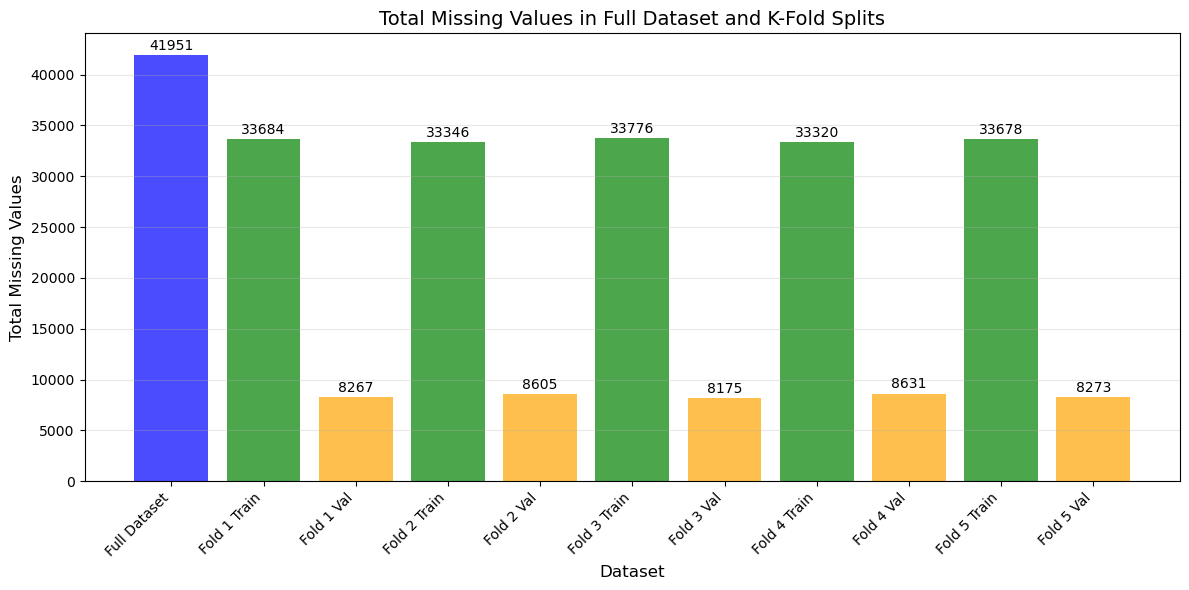

In [42]:
# Calculate missing values for full dataset
total_missing_full = data.isna().sum().sum()

# Calculate missing values for each fold
fold_missing_values = []
fold_names = []
for fold_idx, (train_idx, val_idx) in enumerate(fold_indices, 1):
    train_fold = data.iloc[train_idx]
    val_fold = data.iloc[val_idx]
    
    # Calculate missing values for each fold's train and validation sets
    missing_train = train_fold.isna().sum().sum()
    missing_val = val_fold.isna().sum().sum()
    
    fold_missing_values.extend([missing_train, missing_val])
    fold_names.extend([f'Fold {fold_idx} Train', f'Fold {fold_idx} Val'])

# Create a bar plot
plt.figure(figsize=(12, 6))  # Made wider to accommodate more bars

# Prepare data for plotting
datasets = ['Full Dataset'] + fold_names
missing_values = [total_missing_full] + fold_missing_values

# Create bars with different colors for train and validation sets
colors = []
for i in range(len(datasets)):
    if i == 0:  # Full dataset
        colors.append('blue')
    elif i % 2 == 1:  # Training sets
        colors.append('green')
    else:  # Validation sets
        colors.append('orange')

plt.bar(datasets, missing_values, color=colors, alpha=0.7)
plt.xticks(rotation=45, ha='right')
plt.xlabel('Dataset', fontsize=12)
plt.ylabel('Total Missing Values', fontsize=12)
plt.title('Total Missing Values in Full Dataset and K-Fold Splits', fontsize=14)

# Add value labels above the bars
for i, value in enumerate(missing_values):
    plt.text(i, value + 500, str(value), ha='center', fontsize=10)

plt.grid(True, axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

Missing Values Removal - # Removed


Fold 1:
Removed 24 columns with more than 60% missing values.
Remaining columns: 567

Fold 2:
Removed 24 columns with more than 60% missing values.
Remaining columns: 567

Fold 3:
Removed 24 columns with more than 60% missing values.
Remaining columns: 567

Fold 4:
Removed 24 columns with more than 60% missing values.
Remaining columns: 567

Fold 5:
Removed 24 columns with more than 60% missing values.
Remaining columns: 567

Final Summary:
Number of common columns with >60% missing values across all folds: 24
Dataset shape after dropping columns: (1567, 567)

Columns dropped per fold:
Fold 1: 24 columns
Fold 2: 24 columns
Fold 3: 24 columns
Fold 4: 24 columns
Fold 5: 24 columns


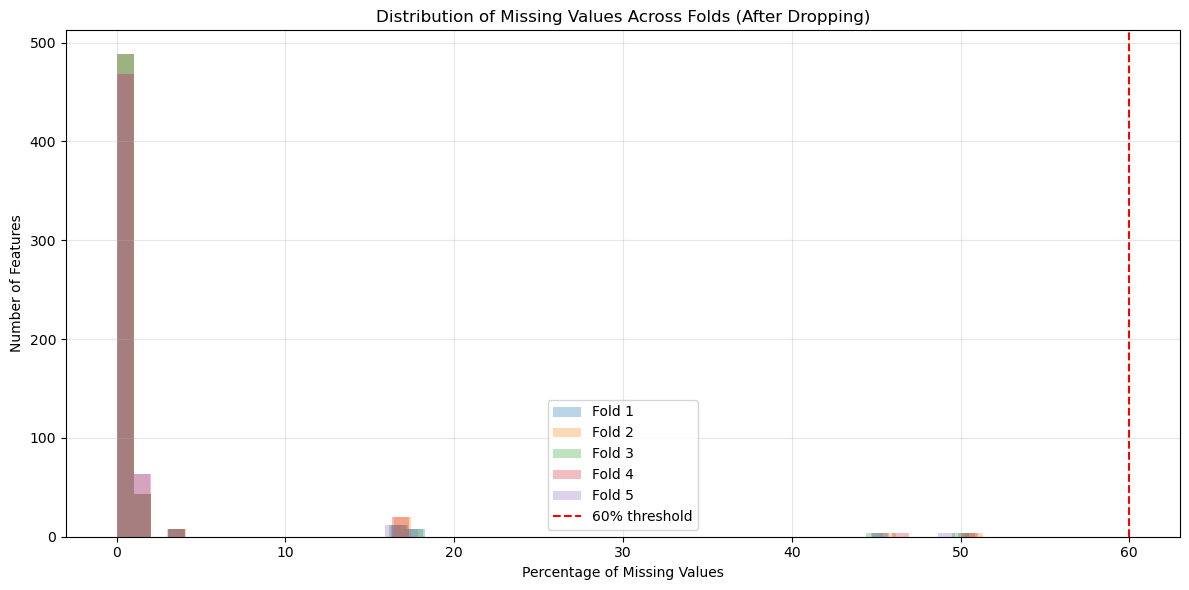

In [44]:
# Initialize storage for fold information
fold_missing_info = []

# Process each fold
for fold_idx, (train_idx, val_idx) in enumerate(fold_indices, 1):
    train_fold = data.iloc[train_idx]
    val_fold = data.iloc[val_idx]
    
    # Calculate missing percentages for training data
    missing_counts = train_fold.isna().sum()
    missing_percentage = (missing_counts / train_fold.shape[0]) * 100
    columns_to_drop = missing_percentage[missing_percentage > 60].index
    
    # Store information about dropped columns
    fold_missing_info.append({
        'fold': fold_idx,
        'n_dropped': len(columns_to_drop),
        'dropped_columns': list(columns_to_drop)
    })
    
    print(f"\nFold {fold_idx}:")
    print(f"Removed {len(columns_to_drop)} columns with more than 60% missing values.")
    print(f"Remaining columns: {train_fold.shape[1] - len(columns_to_drop)}")

# Find common columns to drop across all folds
all_dropped_sets = [set(info['dropped_columns']) for info in fold_missing_info]
common_dropped = set.intersection(*all_dropped_sets)

# Drop the common columns from the entire dataset
data = data.drop(columns=common_dropped)

print("\nFinal Summary:")
print(f"Number of common columns with >60% missing values across all folds: {len(common_dropped)}")
print(f"Dataset shape after dropping columns: {data.shape}")
print("\nColumns dropped per fold:")
for info in fold_missing_info:
    print(f"Fold {info['fold']}: {info['n_dropped']} columns")

# Visualize distribution of missing values after dropping
plt.figure(figsize=(12, 6))
for fold_idx, (train_idx, val_idx) in enumerate(fold_indices, 1):
    train_fold = data.iloc[train_idx]
    missing_percentage = (train_fold.isna().sum() / train_fold.shape[0]) * 100
    plt.hist(missing_percentage, alpha=0.3, label=f'Fold {fold_idx}', bins=50)

plt.axvline(x=60, color='r', linestyle='--', label='60% threshold')
plt.xlabel('Percentage of Missing Values')
plt.ylabel('Number of Features')
plt.title('Distribution of Missing Values Across Folds (After Dropping)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

Scale Train Folds


Fold 1:
Training set shape: (1253, 567)
Validation set shape: (314, 567)


/var/folders/c7/47_sd8tn00398pc3xmjbblh80000gn/T/ipykernel_15236/478422555.py:57: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([X_train_scaled.drop(columns=['status']).values.ravel(),


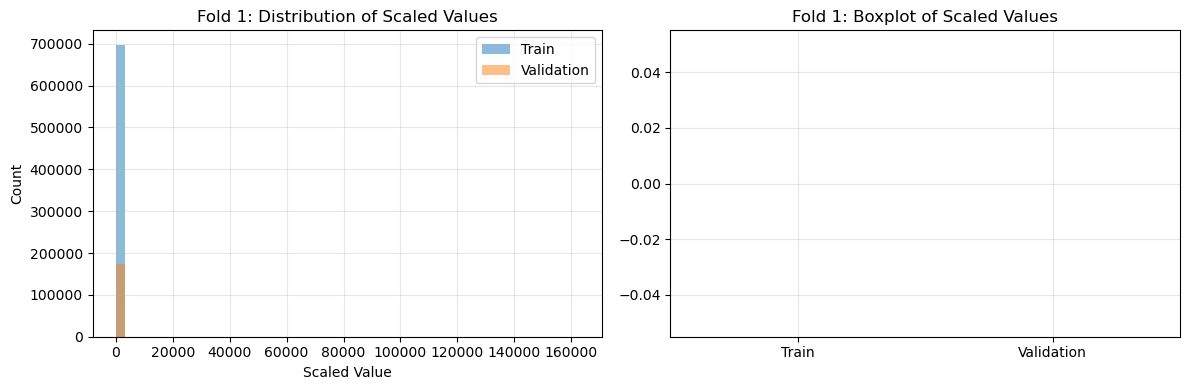


Fold 2:
Training set shape: (1253, 567)
Validation set shape: (314, 567)


/var/folders/c7/47_sd8tn00398pc3xmjbblh80000gn/T/ipykernel_15236/478422555.py:57: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([X_train_scaled.drop(columns=['status']).values.ravel(),


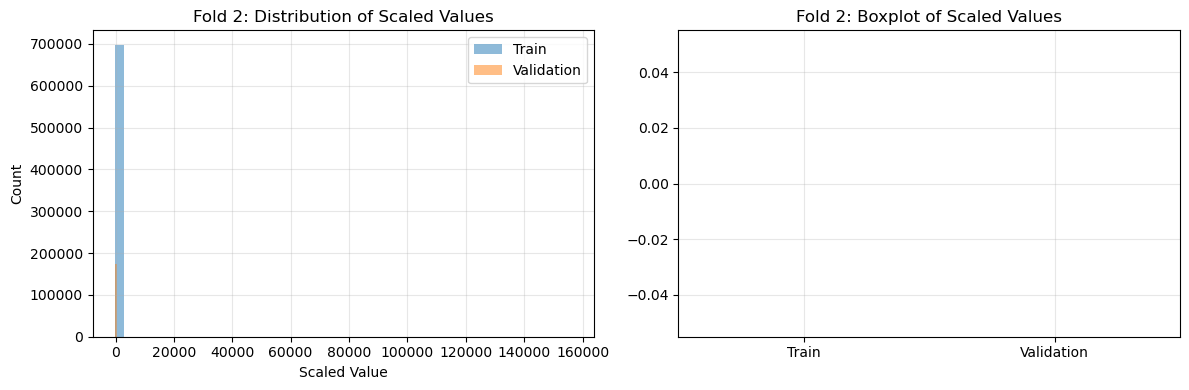


Fold 3:
Training set shape: (1254, 567)
Validation set shape: (313, 567)


/var/folders/c7/47_sd8tn00398pc3xmjbblh80000gn/T/ipykernel_15236/478422555.py:57: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([X_train_scaled.drop(columns=['status']).values.ravel(),


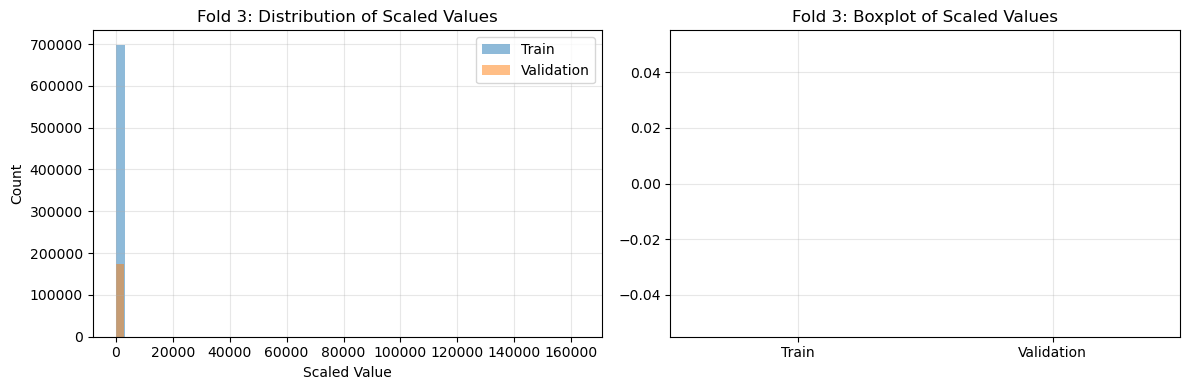


Fold 4:
Training set shape: (1254, 567)
Validation set shape: (313, 567)


/var/folders/c7/47_sd8tn00398pc3xmjbblh80000gn/T/ipykernel_15236/478422555.py:57: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([X_train_scaled.drop(columns=['status']).values.ravel(),


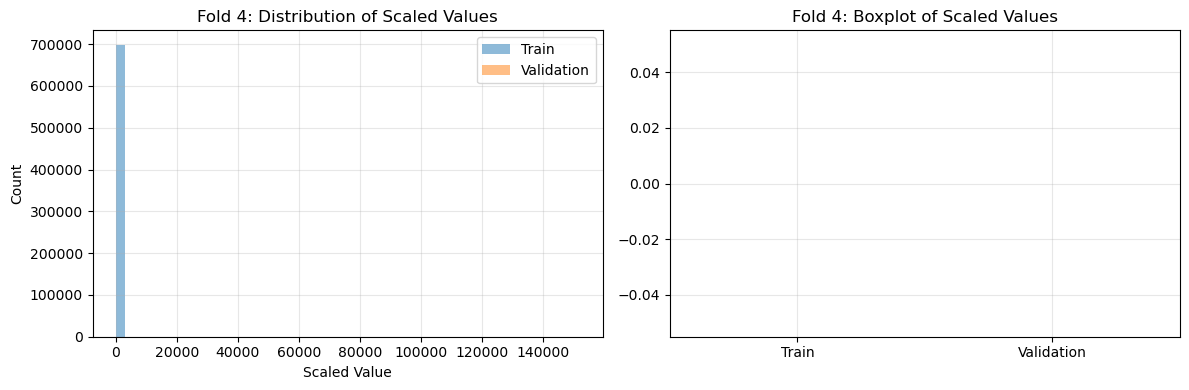


Fold 5:
Training set shape: (1254, 567)
Validation set shape: (313, 567)


/var/folders/c7/47_sd8tn00398pc3xmjbblh80000gn/T/ipykernel_15236/478422555.py:57: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([X_train_scaled.drop(columns=['status']).values.ravel(),


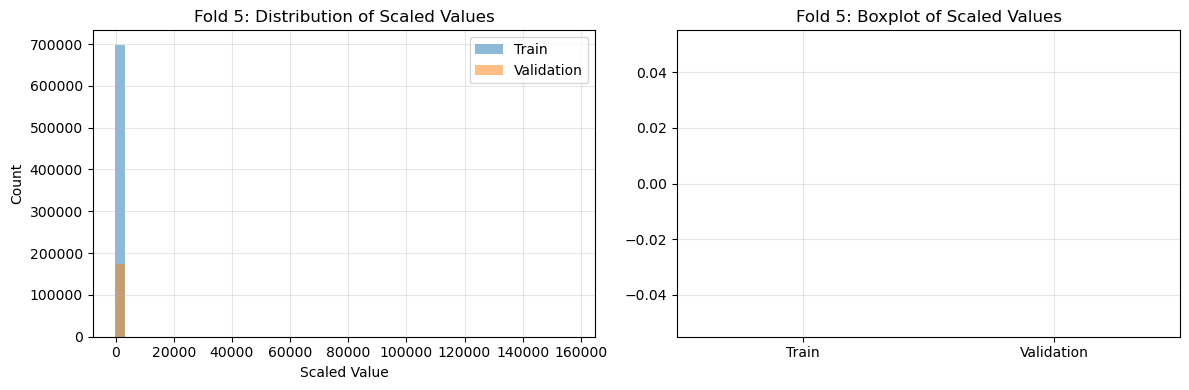

In [45]:
from sklearn.preprocessing import RobustScaler

# Initialize storage for scaled data
scaled_folds = []

# Process each fold
for fold_idx, (train_idx, val_idx) in enumerate(fold_indices, 1):
    # Split into train and validation sets
    train_fold = data.iloc[train_idx]
    val_fold = data.iloc[val_idx]
    
    # Separate features and target
    X_train = train_fold.drop(columns=['status'])
    y_train = train_fold['status']
    X_val = val_fold.drop(columns=['status'])
    y_val = val_fold['status']
    
    # Initialize and fit scaler on training data only
    scaler = RobustScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    # Transform validation data using the same scaler
    X_val_scaled = scaler.transform(X_val)
    
    # Convert back to dataframes with column names
    X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns)
    X_val_scaled = pd.DataFrame(X_val_scaled, columns=X_val.columns)
    
    # Add status back
    X_train_scaled['status'] = y_train.values
    X_val_scaled['status'] = y_val.values
    
    # Store the scaled datasets
    scaled_folds.append({
        'fold': fold_idx,
        'train': X_train_scaled,
        'val': X_val_scaled,
        'scaler': scaler
    })
    
    print(f"\nFold {fold_idx}:")
    print(f"Training set shape: {X_train_scaled.shape}")
    print(f"Validation set shape: {X_val_scaled.shape}")
    
    # Optional: Show distribution of scaled values for this fold
    plt.figure(figsize=(12, 4))
    plt.subplot(121)
    plt.hist(X_train_scaled.drop(columns=['status']).values.ravel(), bins=50, alpha=0.5, label='Train')
    plt.hist(X_val_scaled.drop(columns=['status']).values.ravel(), bins=50, alpha=0.5, label='Validation')
    plt.title(f'Fold {fold_idx}: Distribution of Scaled Values')
    plt.xlabel('Scaled Value')
    plt.ylabel('Count')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # Show boxplot of scaled values
    plt.subplot(122)
    plt.boxplot([X_train_scaled.drop(columns=['status']).values.ravel(),
                 X_val_scaled.drop(columns=['status']).values.ravel()],
                labels=['Train', 'Validation'])
    plt.title(f'Fold {fold_idx}: Boxplot of Scaled Values')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

Impute Missing Values & Confirm Imputation Method


Fold 1:

Average Variances per Column:
Original Data: 103471.7543
Mean Imputation (Scaled): 99611.9374
KNN Imputation: 103361.0995
MICE Imputation: 103105.0531

Fold 2:

Average Variances per Column:
Original Data: 211444.7604
Mean Imputation (Scaled): 208327.5191
KNN Imputation: 211651.8522
MICE Imputation: 210557.3740

Fold 3:

Average Variances per Column:
Original Data: 185874.0640
Mean Imputation (Scaled): 179950.5475
KNN Imputation: 187393.2006
MICE Imputation: 185113.7725

Fold 4:

Average Variances per Column:
Original Data: 203891.4856
Mean Imputation (Scaled): 198790.2350
KNN Imputation: 205200.6316
MICE Imputation: 202998.7066

Fold 5:

Average Variances per Column:
Original Data: 167568.5732
Mean Imputation (Scaled): 165825.7047
KNN Imputation: 167907.7769
MICE Imputation: 166843.5294


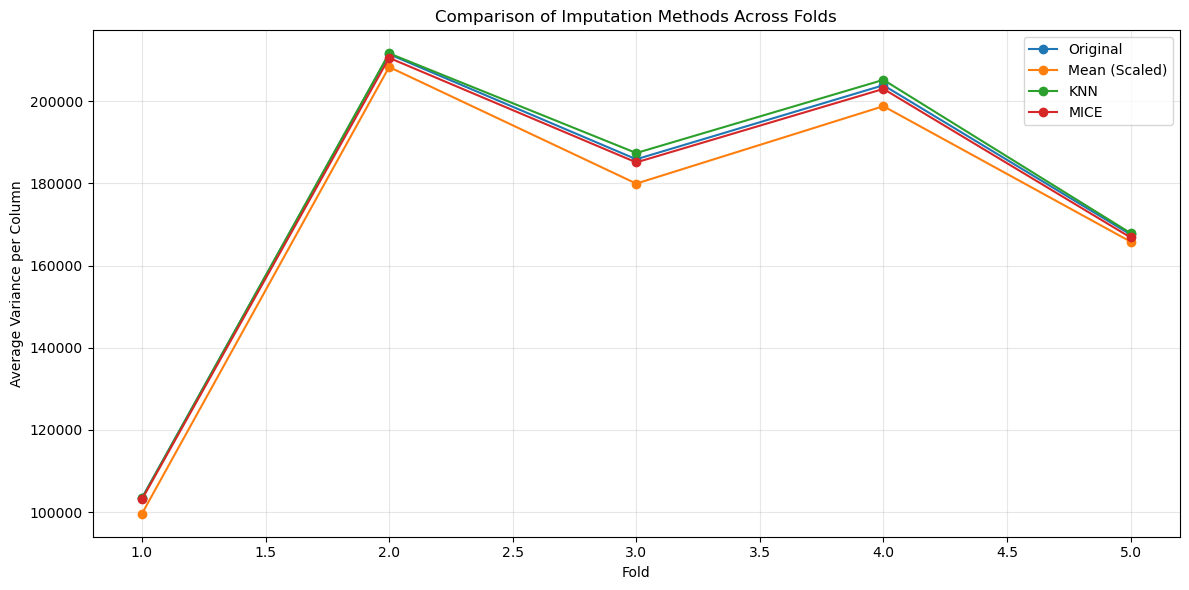


Summary Statistics Across Folds (Average Variance per Column):

Original Imputation:
Mean: 174450.1275
Std: 38603.5957
Min: 103471.7543
Max: 211444.7604

Mean Imputation:
Mean: 170501.1887
Std: 38386.2941
Min: 99611.9374
Max: 208327.5191

Knn Imputation:
Mean: 175102.9122
Std: 38965.1295
Min: 103361.0995
Max: 211651.8522

Mice Imputation:
Mean: 173723.6871
Std: 38413.0429
Min: 103105.0531
Max: 210557.3740


In [49]:
from sklearn.impute import KNNImputer, IterativeImputer
from sklearn.preprocessing import RobustScaler

# Initialize storage for imputation results
fold_imputation_results = []

for fold_idx, (train_idx, val_idx) in enumerate(fold_indices, 1):
    print(f"\nFold {fold_idx}:")
    
    # Get the training data for this fold
    train_fold = data.iloc[train_idx]
    train_fold_scaled = scaled_folds[fold_idx-1]['train']
    
    # Separate features and target before imputation
    X_train_scaled = train_fold_scaled.drop(columns=['status'])
    y_train = train_fold_scaled['status']
    
    # 1. Mean Imputation (on non-scaled data) followed by scaling
    X_train = train_fold.drop(columns=['status'])
    mean_imputed = X_train.fillna(X_train.mean())
    # Scale the mean-imputed data
    scaler = RobustScaler()
    mean_imputed_scaled = pd.DataFrame(
        scaler.fit_transform(mean_imputed),
        columns=X_train.columns
    )
    
    # 2. KNN Imputation (on scaled features only)
    knn_imputer = KNNImputer(n_neighbors=5)
    X_knn_imputed = pd.DataFrame(
        knn_imputer.fit_transform(X_train_scaled),
        columns=X_train_scaled.columns
    )
    
    # 3. MICE Imputation (on scaled features only)
    mice_imputer = IterativeImputer(max_iter=5, random_state=500)
    X_mice_imputed = pd.DataFrame(
        mice_imputer.fit_transform(X_train_scaled),
        columns=X_train_scaled.columns
    )
    
    # Add status back after imputation
    mean_imputed_scaled['status'] = y_train
    X_knn_imputed['status'] = y_train
    X_mice_imputed['status'] = y_train
    
    # Calculate average variances per column (excluding 'status' column)
    var_original = X_train_scaled.var().mean()
    var_mean = mean_imputed_scaled.drop(columns=['status']).var().mean()
    var_knn = X_knn_imputed.drop(columns=['status']).var().mean()
    var_mice = X_mice_imputed.drop(columns=['status']).var().mean()
    
    # Store results
    fold_imputation_results.append({
        'fold': fold_idx,
        'original_var': var_original,
        'mean_var': var_mean,
        'knn_var': var_knn,
        'mice_var': var_mice,
        'mean_imputed': mean_imputed_scaled,
        'knn_imputed': X_knn_imputed,
        'mice_imputed': X_mice_imputed
    })
    
    # Print results for this fold
    print("\nAverage Variances per Column:")
    print(f"Original Data: {var_original:.4f}")
    print(f"Mean Imputation (Scaled): {var_mean:.4f}")
    print(f"KNN Imputation: {var_knn:.4f}")
    print(f"MICE Imputation: {var_mice:.4f}")


# Visualize variance comparisons across folds
plt.figure(figsize=(12, 6))
folds = range(1, 6)
variances = {
    'Original': [res['original_var'] for res in fold_imputation_results],
    'Mean (Scaled)': [res['mean_var'] for res in fold_imputation_results],
    'KNN': [res['knn_var'] for res in fold_imputation_results],
    'MICE': [res['mice_var'] for res in fold_imputation_results]
}

for method, vars in variances.items():
    plt.plot(folds, vars, marker='o', label=method)

plt.xlabel('Fold')
plt.ylabel('Average Variance per Column')
plt.title('Comparison of Imputation Methods Across Folds')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Print summary statistics
print("\nSummary Statistics Across Folds (Average Variance per Column):")
for method in ['original_var', 'mean_var', 'knn_var', 'mice_var']:
    values = [res[method] for res in fold_imputation_results]
    print(f"\n{method.replace('_var', '').title()} Imputation:")
    print(f"Mean: {np.mean(values):.4f}")
    print(f"Std: {np.std(values):.4f}")
    print(f"Min: {np.min(values):.4f}")
    print(f"Max: {np.max(values):.4f}")

Confirm PCA Should Not Be Applied


Fold 1 Linearity Analysis:

Mean Squared Errors:
KNN Imputation: 0.1268
MICE Imputation: 0.1266

Linearity Assessment:
KNN: High error - likely non-linear in nature
MICE: High error - likely non-linear in nature

Fold 2 Linearity Analysis:

Mean Squared Errors:
KNN Imputation: 0.1304
MICE Imputation: 0.1307

Linearity Assessment:
KNN: High error - likely non-linear in nature
MICE: High error - likely non-linear in nature

Fold 3 Linearity Analysis:

Mean Squared Errors:
KNN Imputation: 0.1307
MICE Imputation: 0.1299

Linearity Assessment:
KNN: High error - likely non-linear in nature
MICE: High error - likely non-linear in nature

Fold 4 Linearity Analysis:

Mean Squared Errors:
KNN Imputation: 0.1228
MICE Imputation: 0.1231

Linearity Assessment:
KNN: High error - likely non-linear in nature
MICE: High error - likely non-linear in nature

Fold 5 Linearity Analysis:

Mean Squared Errors:
KNN Imputation: 0.1316
MICE Imputation: 0.1299

Linearity Assessment:
KNN: High error - likely non

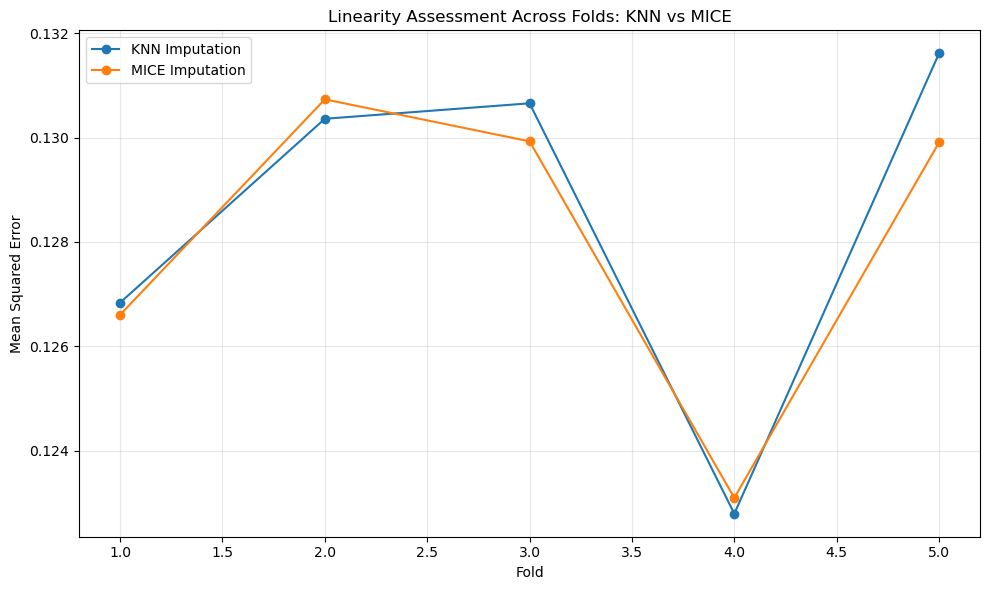


Summary Statistics of MSE Across Folds:

Knn Imputation:
Mean MSE: 0.1285
Std MSE: 0.0033
Min MSE: 0.1228
Max MSE: 0.1316

Mice Imputation:
Mean MSE: 0.1281
Std MSE: 0.0029
Min MSE: 0.1231
Max MSE: 0.1307


In [51]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

# Initialize storage for linearity results
linearity_results = []

for fold_idx, (train_idx, val_idx) in enumerate(fold_indices, 1):
    print(f"\nFold {fold_idx} Linearity Analysis:")
    
    # Get the imputed datasets for this fold (now properly separated)
    knn_imputed = fold_imputation_results[fold_idx-1]['knn_imputed']
    mice_imputed = fold_imputation_results[fold_idx-1]['mice_imputed']
    
    # Function to check linearity
    def check_linearity(data, method_name):
        # Separate features and target
        X = data.drop(columns=['status'])
        y = data['status']
        
        # Fit linear regression model
        linreg = LinearRegression()
        linreg.fit(X, y)
        
        # Predict
        y_pred = linreg.predict(X)
        
        # Calculate MSE
        mse = mean_squared_error(y, y_pred)
        return mse
    
    # Check linearity for KNN and MICE
    mse_knn = check_linearity(knn_imputed, "KNN Imputation")
    mse_mice = check_linearity(mice_imputed, "MICE Imputation")
    
    # Store results
    linearity_results.append({
        'fold': fold_idx,
        'knn_mse': mse_knn,
        'mice_mse': mse_mice
    })
    
    # Print results for this fold
    print(f"\nMean Squared Errors:")
    print(f"KNN Imputation: {mse_knn:.4f}")
    print(f"MICE Imputation: {mse_mice:.4f}")
    
    print("\nLinearity Assessment:")
    for method, mse in [("KNN", mse_knn), ("MICE", mse_mice)]:
        if mse < 0.1:
            print(f"{method}: Low error - likely linear in nature")
        else:
            print(f"{method}: High error - likely non-linear in nature")

# Visualize MSE comparisons across folds
plt.figure(figsize=(10, 6))
folds = range(1, 6)
mse_values = {
    'KNN Imputation': [res['knn_mse'] for res in linearity_results],
    'MICE Imputation': [res['mice_mse'] for res in linearity_results]
}

for method, mses in mse_values.items():
    plt.plot(folds, mses, marker='o', label=method)

plt.xlabel('Fold')
plt.ylabel('Mean Squared Error')
plt.title('Linearity Assessment Across Folds: KNN vs MICE')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Print summary statistics
print("\nSummary Statistics of MSE Across Folds:")
for method in ['knn_mse', 'mice_mse']:
    values = [res[method] for res in linearity_results]
    print(f"\n{method.replace('_mse', '').title()} Imputation:")
    print(f"Mean MSE: {np.mean(values):.4f}")
    print(f"Std MSE: {np.std(values):.4f}")
    print(f"Min MSE: {np.min(values):.4f}")
    print(f"Max MSE: {np.max(values):.4f}")

Execute Feature Selection - Boruta & Re-Check Any Correlated Values Remaining


Fold 1 Boruta Analysis:

Number of selected features: 12
Selected features: ['col3', 'col22', 'col39', 'col41', 'col60', 'col65', 'col66', 'col154', 'col349', 'col427', 'col442', 'col563']

Number of tentative features: 3
Tentative features: ['col289', 'col552', 'col558']

Fold 2 Boruta Analysis:

Number of selected features: 12
Selected features: ['col39', 'col41', 'col60', 'col65', 'col66', 'col104', 'col211', 'col268', 'col349', 'col442', 'col478', 'col540']

Number of tentative features: 0
Tentative features: []

Fold 3 Boruta Analysis:

Number of selected features: 11
Selected features: ['col27', 'col60', 'col65', 'col66', 'col104', 'col154', 'col427', 'col478', 'col540', 'col558', 'col563']

Number of tentative features: 1
Tentative features: ['col268']

Fold 4 Boruta Analysis:

Number of selected features: 14
Selected features: ['col60', 'col65', 'col66', 'col104', 'col154', 'col206', 'col268', 'col289', 'col342', 'col349', 'col427', 'col442', 'col478', 'col563']

Number of ten

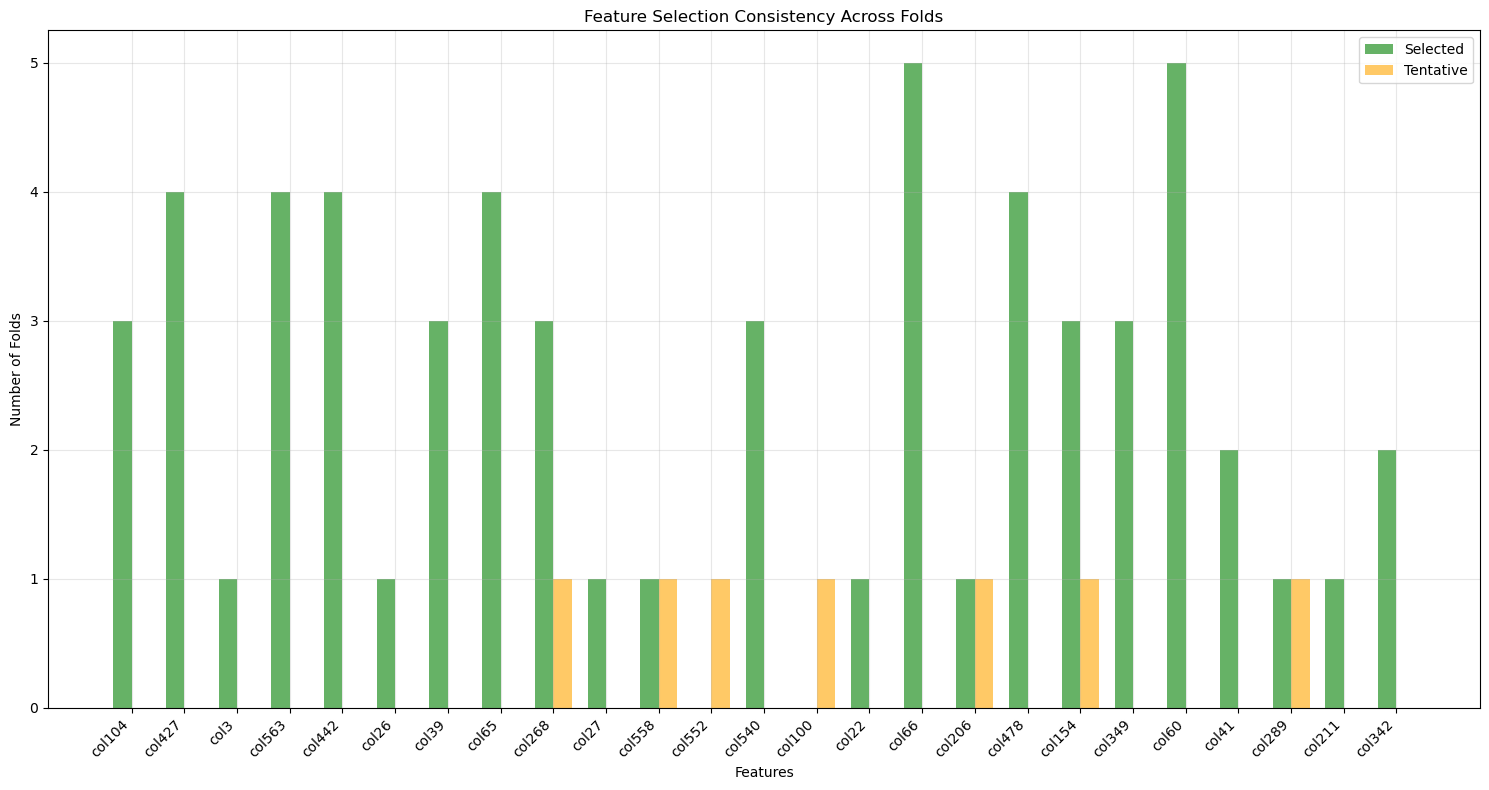

In [52]:
from boruta import BorutaPy
from sklearn.ensemble import RandomForestClassifier
import numpy as np

# Initialize storage for Boruta results
boruta_results = []

for fold_idx, (train_idx, val_idx) in enumerate(fold_indices, 1):
    print(f"\nFold {fold_idx} Boruta Analysis:")
    
    # Get the KNN imputed data for this fold
    knn_imputed = fold_imputation_results[fold_idx-1]['knn_imputed']
    
    # Prepare features and target
    X = knn_imputed.drop(columns=['status'])
    y = knn_imputed['status']
    
    # Initialize RandomForestClassifier for Boruta
    rf = RandomForestClassifier(n_jobs=-1, max_depth=5, random_state=40)
    
    # Initialize Boruta
    boruta = BorutaPy(rf, n_estimators='auto', max_iter=100, random_state=40)
    
    # Fit Boruta
    boruta.fit(X.values, y.values)
    
    # Get selected and tentative features
    selected_features = X.columns[boruta.support_].tolist()
    tentative_features = X.columns[boruta.support_weak_].tolist()
    
    # Store results
    boruta_results.append({
        'fold': fold_idx,
        'selected_features': selected_features,
        'tentative_features': tentative_features,
        'n_selected': len(selected_features),
        'n_tentative': len(tentative_features)
    })
    
    # Print results for this fold
    print(f"\nNumber of selected features: {len(selected_features)}")
    print(f"Selected features: {selected_features}")
    print(f"\nNumber of tentative features: {len(tentative_features)}")
    print(f"Tentative features: {tentative_features}")

# Analyze consistency across folds
all_features = set()
for result in boruta_results:
    all_features.update(result['selected_features'])
    all_features.update(result['tentative_features'])

# Create a feature consistency matrix
feature_consistency = {feature: {'selected': 0, 'tentative': 0} for feature in all_features}

for result in boruta_results:
    for feature in all_features:
        if feature in result['selected_features']:
            feature_consistency[feature]['selected'] += 1
        elif feature in result['tentative_features']:
            feature_consistency[feature]['tentative'] += 1

# Print consistency analysis
print("\nFeature Selection Consistency Across Folds:")
print("\nFeatures selected in all 5 folds:")
for feature, counts in feature_consistency.items():
    if counts['selected'] == 5:
        print(f"- {feature}")

print("\nFeatures selected in 4 or more folds:")
for feature, counts in feature_consistency.items():
    if counts['selected'] >= 4:
        print(f"- {feature} (selected in {counts['selected']} folds)")

print("\nFeature Selection Summary:")
for feature, counts in feature_consistency.items():
    print(f"\n{feature}:")
    print(f"- Selected in {counts['selected']} folds")
    print(f"- Tentative in {counts['tentative']} folds")

# Visualize feature selection consistency
plt.figure(figsize=(15, 8))
features = list(all_features)
selected_counts = [feature_consistency[f]['selected'] for f in features]
tentative_counts = [feature_consistency[f]['tentative'] for f in features]

x = np.arange(len(features))
width = 0.35

plt.bar(x - width/2, selected_counts, width, label='Selected', color='green', alpha=0.6)
plt.bar(x + width/2, tentative_counts, width, label='Tentative', color='orange', alpha=0.6)

plt.xlabel('Features')
plt.ylabel('Number of Folds')
plt.title('Feature Selection Consistency Across Folds')
plt.xticks(x, features, rotation=45, ha='right')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [53]:
# Create DataFrame for features selected at least once
selected_features_df = pd.DataFrame([
    {
        'Feature': feature,
        'Times_Selected': counts['selected'],
        'Times_Tentative': counts['tentative']
    }
    for feature, counts in feature_consistency.items()
    if counts['selected'] > 0  # Only features selected at least once
]).sort_values('Times_Selected', ascending=False)

print("\nFeatures Selected At Least Once (Green):")
print(selected_features_df)

# Create DataFrame for features that were either selected or tentative at least once
all_important_features_df = pd.DataFrame([
    {
        'Feature': feature,
        'Times_Selected': counts['selected'],
        'Times_Tentative': counts['tentative'],
        'Total_Appearances': counts['selected'] + counts['tentative']
    }
    for feature, counts in feature_consistency.items()
    if counts['selected'] + counts['tentative'] > 0  # Features that appeared at least once in either category
]).sort_values(['Times_Selected', 'Times_Tentative'], ascending=[False, False])

print("\nAll Important Features (Green + Orange):")
print(all_important_features_df)

# Optional: Add some summary statistics
print("\nSummary:")
print(f"Number of features selected at least once: {len(selected_features_df)}")
print(f"Number of features either selected or tentative at least once: {len(all_important_features_df)}")


Features Selected At Least Once (Green):
   Feature  Times_Selected  Times_Tentative
18   col60               5                0
13   col66               5                0
1   col427               4                0
3   col563               4                0
4   col442               4                0
7    col65               4                0
15  col478               4                0
0   col104               3                0
17  col349               3                0
16  col154               3                1
11  col540               3                0
8   col268               3                1
6    col39               3                0
19   col41               2                0
22  col342               2                0
10  col558               1                1
12   col22               1                0
9    col27               1                0
14  col206               1                1
5    col26               1                0
2     col3               1        

Balancing Using SMOTE

Execute Random Forest